## A neural network for regression using the adam optimization algorithm.

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import os
from abc import ABC, abstractmethod

In [2]:
np.random.seed(4)

In [3]:
DATA_HOME = './data'

In [4]:
class ActivationFunction(ABC):
    """ An abstract class serving as a template for activation functions used 
    in :class:'NeuralNetwork'.
    """
    
    @abstractmethod
    def __call__(self, X):
        pass
    
    @abstractmethod
    def derivative(self, X):
        pass
    
    
class ReluActivation(ActivationFunction):
    """ A ReLU activation function.
    """
    
    def __call__(self, X):
        X = X.copy()
        X[X < 0] = 0
        return X
    
    def derivative(self, X):
        X = X.copy()
        X[X >= 0] = 1  # Approximating the derivative at 0
        X[X < 0] = 0
        return X

In [5]:
class NeuralNetwork:
    """ A neural network model for regression. Uses quadratic cost to fit the model's
    parameters. Enforces a linear activation function in the output layer (i.e. f(x)=x).
    Weights are initialized randomly, biases are initialized to zeros.

    :param layers: An array of integers corresponding to the number of units in each 
    of the layers, including and input and output layer (i.e. input and output dimensionality).
    :param activation_func: A :class:'ActivationFunction' object to use as the activation 
    function in all layers except for the output and input ones.
    """

    def __init__(self, layers, activation_func):
        self.layers = layers
        self.activation_func = activation_func
        self._initialize_weights()

    def _initialize_weights(self):
        """ Initializes the model's parameters. Weight matrices are initialized randomly 
        from a N(0, 0.01) distribution. Biases are initialized to zeros.
        """
        self._weights = []
        self._biases = []
        for l_previous, l_next in zip(self.layers[:-1], self.layers[1:]):
            self._weights.append(np.random.normal(loc=0.0, scale=0.1, size=(l_next, l_previous)))
            self._biases.append(np.zeros(shape=(l_next, 1)))

    def fit(self, X, Y, l_rate=0.01, momentum_param=0.9, rmsprop_param=0.999, rmsprop_epsilon=10e-8,
            n_iter=1000, return_costs=False):
        """ Initializes the parameters of the model randomly and sets them using 
        batch gradient descent with momentum and rmsprop (i.e. Adam optimization algorithm).

        :param X: A numpy.ndarray of observations of shape (n_observations, n_features).
        :param Y: A numpy.ndarray of outcomes corresponding to the observations in ''X'',
        of shape (n_observations, n_outcomes).
        :param momentum_param: Hyperparameter controlling the momentum moving average's sensitivity 
        to previous observations.
        :param rmsprop_param: Hyperparameter controlling the rmsprop moving average's sensitivity 
        to previous observations.
        :param epsilon: The number added to the denominator for numerical stability
        (should be very small).
        :param l_rate: Learning rate to use for gradient descent.
        :param n_iter: Number of training epochs to run GD for.
        :param return_costs: If ''True'' returns an array of costs on each epoch.
        """
        self._initialize_weights()
        X = X.copy()
        X = X.T
        Y = Y.copy()
        Y = Y.T
        return self.GD(X, Y, l_rate, momentum_param, rmsprop_param, rmsprop_epsilon, n_iter, return_costs)

    def predict(self, X):
        """ Computes predictions for a given input. Assumes the model is 
        already trained.

        :param X: A numpy.ndarray of observations of shape (n_observations, n_features).
        :returns: A vector of shape (n_observations, n_outcomes), indicating the predicted outcome
        for each observation.
        """
        X = X.copy()
        X = X.T
        Y_hat = self.forward(X)
        return Y_hat.T

    def forward(self, X, return_intermediate=False):
        """ Computes the output of the model.

        :param X: A numpy.ndarray of observations of shape (n_features, n_observations).
        :param return_intermediate: If True returns activations and weighted sums from all network layers, 
        as a tuple of (activations, weighted_sums). Otherwise returns only the activations from the output
        layer.
        """
        activations = []
        weighted_sums = []
        A_previous = X.copy()
        for W, b in zip(self._weights[:-1], self._biases[:-1]):
            Z_next = W @ A_previous + b
            A_next = self.activation_func(Z_next)
            weighted_sums.append(Z_next)
            activations.append(A_next)
            A_previous = A_next

        # Enforcing no activation function in the last layer
        Z_last = self._weights[-1] @ A_previous + self._biases[-1]
        A_last = Z_last
        weighted_sums.append(Z_last)
        activations.append(A_last)
        if return_intermediate:
            return activations, weighted_sums
        else:
            return A_last

    def backward(self, X, Y):
        """ Computes the derivatives of the cost function (denoted J) wrt. the model's parameters.

        :param X: A numpy.ndarray of observations of shape (n_features, n_observations).
        :param Y: A numpy.ndarray of outcomes corresponding to the observations in ''X'',
        of shape (n_observations, n_outcomes).
        :returns gradients_W: The gradients of the cost function (J) wrt. to the model's parameters, 
        corresponding to each of the weight matrices in ''self._weights''.
        :returns gradients_b: The gradients of the cost function (J) wrt. to the model's parameters,
        corresponding to each of the bias vectors in ''self._biases''.
        """
        m = X.shape[1]
        gradients_W, gradients_b = [], []
        activations, weighted_sums = self.forward(X, return_intermediate=True)

        A = activations[-1]
        dJ_dZ = A - Y
        for A, Z, W in zip(reversed(activations[:-1]), reversed(weighted_sums[:-1]), self._weights[::-1]):
            dJ_dW = (2. / m) * (dJ_dZ @ A.T)
            dJ_db = (2. / m) * np.sum(dJ_dZ, axis=1, keepdims=True) 
            gradients_W.append(dJ_dW)
            gradients_b.append(dJ_db)
            dJ_dZ = (W.T @ dJ_dZ) * self.activation_func.derivative(Z)

        # Derivatives wrt. to the first weight matrix / bias vector are computed outside of the loop 
        # to avoid appending ''X'' to the ''activations'' list.
        dJ_dW1 = (2. / m) * (dJ_dZ @ X.T)
        dJ_db1 = (2. / m) * np.sum(dJ_dZ, axis=1, keepdims=True)
        gradients_W.append(dJ_dW1)
        gradients_b.append(dJ_db1)

        return gradients_W[::-1], gradients_b[::-1]

    def GD(self, X, Y, l_rate=0.1, momentum_param=0.9, rmsprop_param=0.999, epsilon=10e-8,
           n_iter=1000, return_costs=False):
        """ Performs gradient descent with momentum and rmsprop (i.e. uses the Adam optimization algorithm).

       :param X: A numpy.ndarray of observations of shape (n_features, n_observations).
       :param Y: A numpy.ndarray of outcomes corresponding to the observations in ''X'',
       of shape (n_outcomes, n_observations).
       :param l_rate: Learning rate to use for gradient descent.
       :param momentum_param: Hyperparameter controlling the momentum moving average's sensitivity 
       to previous observations.
       :param rmsprop_param: Hyperparameter controlling the rmsprop moving average's sensitivity 
       to previous observations.
       :param epsilon: The number added to the denominator for numerical stability (should be very small).
       :param n_iter: Number of training epochs to run GD for.
       :param return_costs: If ''True'' returns an array of costs on each epoch.
       """
        # Running averages for Adam
        momentum_avgs_W = [np.zeros(W.shape) for W in self._weights]
        momentum_avgs_b = [np.zeros(b.shape) for b in self._biases]
        rmsprop_avgs_W = [np.zeros(W.shape) for W in self._weights]
        rmsprop_avgs_b = [np.zeros(b.shape) for b in self._biases]
        
        if return_costs:
            costs = []
        for epoch in range(1, n_iter+1):
            gradients_W, gradients_b = self.backward(X, Y)
            for i, (dJ_dW, dJ_db) in enumerate(zip(gradients_W, gradients_b)):
                # Adam updates
                momentum_avgs_W[i] = momentum_param * momentum_avgs_W[i] + (1 - momentum_param) * dJ_dW
                momentum_avgs_b[i] = momentum_param * momentum_avgs_b[i] + (1 - momentum_param) * dJ_db
                rmsprop_avgs_W[i] = rmsprop_param * rmsprop_avgs_W[i] + (1 - rmsprop_param) * (dJ_dW ** 2)
                rmsprop_avgs_b[i] = rmsprop_param * rmsprop_avgs_b[i] + (1 - rmsprop_param) * (dJ_db ** 2)
                # Bias correction
                momentum_W_corrected = momentum_avgs_W[i] / (1 - (momentum_param ** epoch))
                momentum_b_corrected = momentum_avgs_b[i] / (1 - (momentum_param ** epoch))
                rmsprop_W_corrected = rmsprop_avgs_W[i] / (1 - (rmsprop_param ** epoch))
                rmsprop_b_corrected = rmsprop_avgs_b[i] / (1 - (rmsprop_param ** epoch))
                
                self._weights[i] = self._weights[i] - l_rate * (momentum_W_corrected / (rmsprop_W_corrected ** 0.5 + epsilon))
                self._biases[i] = self._biases[i] - l_rate * (momentum_b_corrected / (rmsprop_b_corrected ** 0.5 + epsilon))
            if return_costs:
                Y_hat = self.forward(X)
                costs.append(NeuralNetwork.quadratic_cost(Y, Y_hat))
        if return_costs:
            return costs

    @staticmethod
    def quadratic_cost(Y, Y_hat):
        n_observations = Y.shape[1]
        return (1. / n_observations) * np.sum((Y_hat - Y) ** 2)

    @staticmethod
    def plot_costs(costs):
        plt.xlabel('Epoch')
        plt.ylabel('Cost')
        plt.plot(costs)
        plt.show()

In [6]:
data = pd.read_csv(os.path.join(DATA_HOME, 'linreg_data.txt'), header=None, delimiter='\s+', names=['x', 'y'], dtype={0: np.float64, 1: np.float64})

In [7]:
X_train, X_test, y_train, y_test = train_test_split(data['x'].to_numpy(), data['y'].to_numpy(), test_size=0.3, shuffle=True)

In [8]:
X_train, X_test = X_train.reshape(-1, 1), X_test.reshape(-1, 1)
y_train, y_test = y_train.reshape(-1, 1), y_test.reshape(-1, 1)

In [9]:
scaler = StandardScaler()

In [10]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

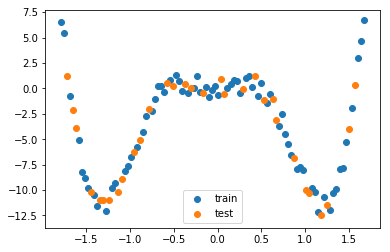

In [11]:
plt.scatter(X_train, y_train, color='tab:blue', label='train')
plt.scatter(X_test, y_test, color='tab:orange', label='test')
plt.legend()
plt.show()

In [12]:
model = NeuralNetwork([1, 20, 20, 1], activation_func=ReluActivation())

In [13]:
costs = model.fit(X_train, y_train, l_rate=0.003, n_iter=3000, return_costs=True)

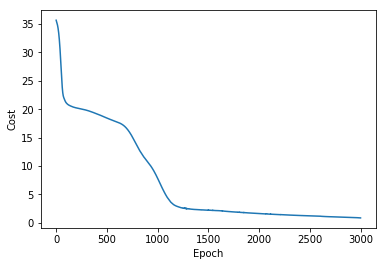

In [14]:
NeuralNetwork.plot_costs(costs)

In [15]:
y_hat = model.predict(X_test)

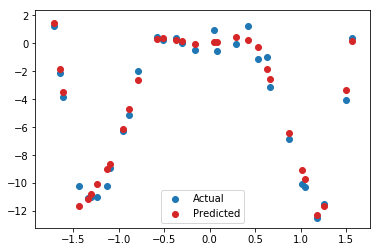

In [16]:
results = np.concatenate((X_test, y_test, y_hat), axis=1)
results = results[results[:, 0].argsort()]
plt.scatter(results[:, 0], results[:, 1], color='tab:blue', label='Actual')
plt.scatter(results[:, 0], results[:, 2], color='tab:red', label='Predicted')
plt.legend()
plt.show()

In [17]:
print(f'Test set RMSE: {NeuralNetwork.quadratic_cost(y_test.T, y_hat.T) ** 0.5}')

Test set RMSE: 0.6208963879343948
